In [107]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
import numpy as np
from numpy import datetime64
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import KDTree,RadiusNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler
import itertools
import time
import matplotlib.pyplot as plt

In [108]:
gnss_df = pd.read_csv(
    "/Users/franklyndunbar/Project/SeaFloorGeodesy/es_sfgtools/gnss.csv"
)
shotdata_df = pd.read_csv(
    "/Users/franklyndunbar/Project/SeaFloorGeodesy/es_sfgtools/shotdata.csv"
)
gnss_df.time = gnss_df.time.apply(lambda x: pd.Timestamp(x).timestamp())
shotdata_df.pingTime = shotdata_df.pingTime.apply(lambda x: pd.Timestamp(x).timestamp())
shotdata_df.returnTime = shotdata_df.returnTime.apply(lambda x: pd.Timestamp(x).timestamp())

In [327]:
# shotdata_df_distilled = shotdata_df.drop_duplicates("pingTime")
delta_tenur = (
    shotdata_df[["east1", "north1", "up1"]].to_numpy()
    - shotdata_df[["east0", "north0", "up0"]].to_numpy()
)
gnss_data_interpolation = gnss_df[["time", "east", "north", "up"]].to_numpy()
X_train = gnss_df[["time"]].to_numpy()
Y_train = gnss_df[["east", "north", "up"]].to_numpy()

XY_predict_ping = shotdata_df[["pingTime", "east0", "north0", "up0"]].to_numpy()
XY_predict_return = shotdata_df[["returnTime", "east1", "north1", "up1"]].to_numpy()
isUpdated = shotdata_df["isUpdated"].to_numpy()[:, np.newaxis]

X_train = np.vstack((X_train,XY_predict_ping[:, 0][:,np.newaxis],XY_predict_return[:, 0][:,np.newaxis]))
Y_train = np.vstack((Y_train, XY_predict_ping[:, 1:], XY_predict_return[:, 1:]))


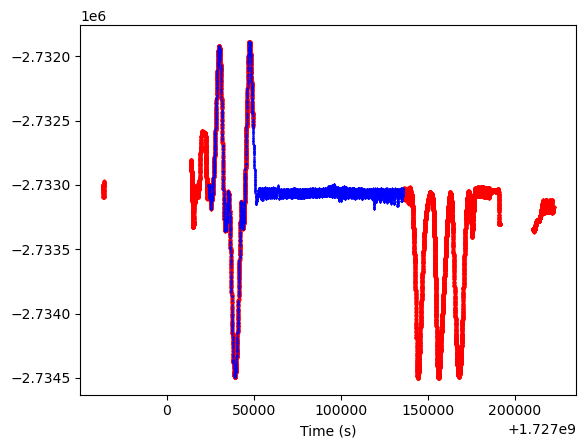

In [130]:
plt.clf()
plt.plot(X_train, Y_train[:, 0], "r.", markersize=3, label="East")
plt.plot(XY_predict_ping[:, 0], XY_predict_ping[:, 1], "b.", markersize=.5, label="East Ping")
#plt.plot(XY_predict_return[:, 0], XY_predict_return[:, 1], "g.", markersize=.25, label="East Return")
plt.xlabel("Time (s)")
plt.show()

In [246]:
def gen_weights(distances:np.ndarray) -> np.ndarray:
    print(distances.shape)
  
    # Generate weights based on distances
    # If all distances are zero, we can return the weights as is as we are using the input values directly
    # If there is at least one non-zero distance we will use the closest point as the reference
    atol = 1e-9
    #distances = np.maximum(distances, atol)  # Avoid division by zero
    original_ind = np.argmin(distances,axis=1)  # Get the index of the closest point for each row

    to_null = np.array(np.isclose(distances, np.zeros_like(distances), atol=atol))

    for i in range(distances.shape[0]):
        if np.all(to_null[i]):
            distances[i,:] = 0
            distances[i, original_ind[i]] = 1.0
        else:
      

            #distances[i,to_null[i]] = np.nan  # Ensure no distance is zero to avoid division by zero
            distances[i,:] = 1/distances[i,:]  # Invert distances to get weights
            distances[i,original_ind[i]] = atol  # Set the closest point to zero distance
      
            distances[i,:] /= np.sum(distances[i,:])  # Normalize weights to sum to 1
         

    return distances

In [245]:
test = np.array([[.1, .2, 1e-6, .4, .5],[.1, .2, 1e-6, .4, .5]]).squeeze()
print(np.argmin(test, axis=1))
print(gen_weights(test))

[2 2]
(2, 5)
original_ind: [2 2]
[False False]
[1.e-01 2.e-01 1.e-06 4.e-01 5.e-01]
inverted distances for row 0: [1.0e+01 5.0e+00 1.0e-09 2.5e+00 2.0e+00]
Row 0: [5.12820513e-01 2.56410256e-01 5.12820513e-11 1.28205128e-01
 1.02564103e-01]
[1.e-01 2.e-01 1.e-06 4.e-01 5.e-01]
inverted distances for row 1: [1.0e+01 5.0e+00 1.0e-09 2.5e+00 2.0e+00]
Row 1: [5.12820513e-01 2.56410256e-01 5.12820513e-11 1.28205128e-01
 1.02564103e-01]
[[5.12820513e-01 2.56410256e-01 5.12820513e-11 1.28205128e-01
  1.02564103e-01]
 [5.12820513e-01 2.56410256e-01 5.12820513e-11 1.28205128e-01
  1.02564103e-01]]


In [289]:
lengthscale=.1 # seconds
GNSS_DATA_TREE = RadiusNeighborsRegressor(
    radius=lengthscale, weights='uniform', algorithm="kd_tree"
)
GNSS_DATA_TREE.fit(X_train, Y_train)
# err = GNSS_DATA_TREE.score(
#     XY_predict_ping[:, 0][:, np.newaxis],
#     XY_predict_ping[:, 1:],
# )


train_score = GNSS_DATA_TREE.score(X_train, Y_train)
print(f"Training Score: {train_score}")
# print(f"Prediction Score: {err}")

Training Score: 0.9999992291472234


In [316]:
pred_ping = GNSS_DATA_TREE.predict(XY_predict_ping[:, 0][:, np.newaxis])
pred_return = GNSS_DATA_TREE.predict(XY_predict_return[:, 0][:, np.newaxis])
train_inds = GNSS_DATA_TREE.radius_neighbors(
    XY_predict_ping[:, 0][:, np.newaxis], return_distance=False
)


In [306]:
offset = np.abs(pred_ping - XY_predict_ping[:, 1:])
mean_east = np.mean(pred_ping[:, 0])
print(offset.max())

6.226273742038757


In [341]:
offset_ping = np.abs(pred_ping - XY_predict_ping[:, 1:])
offset_return = np.abs(pred_return - XY_predict_return[:, 1:])

In [359]:
# update isUpdated flag
isUpdated_1 = np.logical_or(isUpdated, np.any((offset_ping > 1e-3),axis=1)[:, np.newaxis])
isUpdated_2 = np.logical_or(isUpdated_1, np.any((offset_return > 1e-3),axis=1)[:, np.newaxis])

In [360]:
test = np.any((offset_ping > 1e-3),axis=1)
test.shape
isUpdated.shape

(20503, 1)

In [361]:
print(isUpdated.shape)
print(isUpdated_1.shape)
print(offset_ping.shape)

(20503, 1)
(20503, 1)
(20503, 3)


In [345]:
isUpdated_1

array([[False, False, False],
       [False, False, False],
       [False, False, False],
       ...,
       [False, False, False],
       [False, False, False],
       [False, False, False]])

In [362]:
isUpdated_2.astype(int).sum() / isUpdated_2.shape[0]

0.5029995610398478

<Figure size 640x480 with 0 Axes>

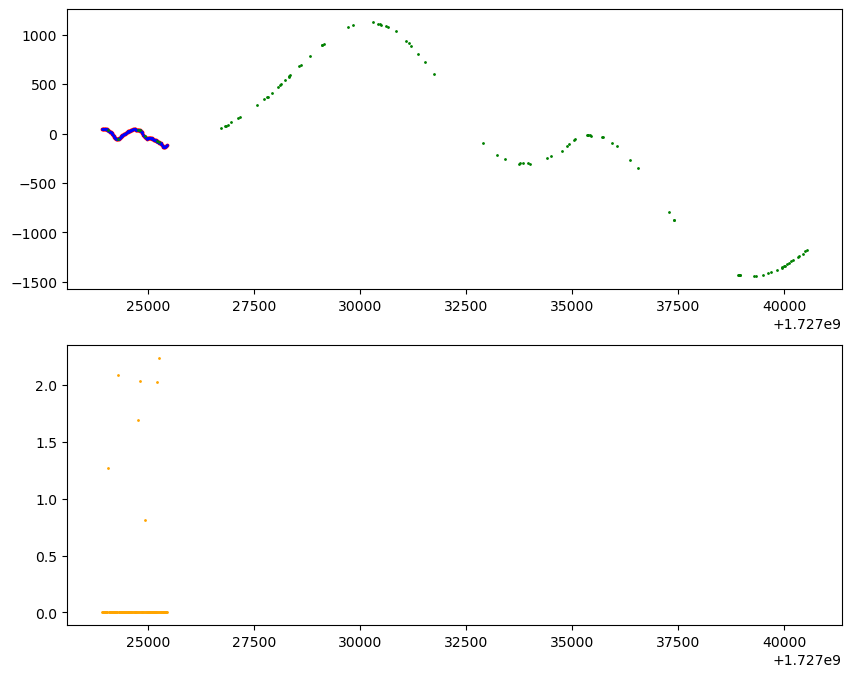

In [ ]:
cutoff = 100
plt.clf()
fig,axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
axes[0].sharex(axes[1])
axes[0].scatter(XY_predict_ping[:cutoff, 0], pred_ping[:cutoff, 0] - mean_east, color='red', s=3, label="East Offset Ping")
axes[0].scatter(XY_predict_ping[:cutoff, 0], XY_predict_ping[:cutoff, 1] - mean_east, color='blue',s=1, label="East Offset Ping")

axes[1].scatter(XY_predict_ping[:cutoff, 0], offset[:cutoff, 1],label="North Offset Ping", color="orange", s=1)

In [ ]:
scaler = StandardScaler(
    with_std=False
)  # we do not want to scale the standard deviation
scaler.fit(gnss_data_interpolation[gnss_training_data_inds, :])

XY_train = scaler.transform(
    gnss_data_interpolation[gnss_training_data_inds, :]
)  # East, North, Up values
XY_predict = scaler.transform(shotdata_to_update[:, 0:-1])  # East, North, Up values

X_train = XY_train[:, 0][:, np.newaxis]  # timestamps
Y_train = XY_train[:, 1:]  # East, North, Up values
X_predict = XY_predict[:, 0][:, np.newaxis]  # timestamps for the points to update
# create the kernel ridge regression model


Text(0.5, 0, 'Time (s)')

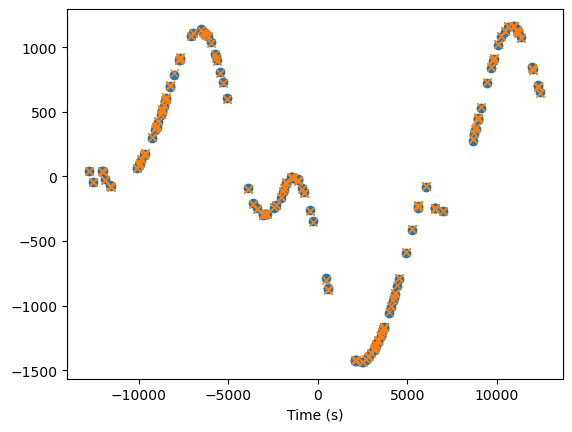

In [ ]:
plt.plot(X_train, Y_train[:, 0], "o", label="Training Data East")
plt.plot(X_predict, XY_predict[:, 1], "x", label="Prediction Points East")
plt.xlabel("Time (s)")

In [ ]:
kernel = RBF(length_scale=lengthscale)
kernal_ridge = KernelRidge(alpha=0.5, kernel=kernel)
kernal_ridge = kernal_ridge.fit(X_train, Y_train)
err = kernal_ridge.score(
    XY_predict[:, 0][:, np.newaxis],
    XY_predict[:, 1:],
)

train_score = kernal_ridge.score(X_train, Y_train)
print(f"Training Score: {train_score}")
print(f"Prediction Score: {err}")
# predict the values at the tenu_r timestamps
updated_shotdata_scaled = kernal_ridge.predict(X_predict)
# create a merged array with each column being the East, North, Up values
# and the first column being the timestamps


Training Score: 0.888888888888889
Prediction Score: 0.6456367318332993


In [ ]:
updated_shotdata_scaled_merged = np.hstack((X_predict, updated_shotdata_scaled))

In [ ]:
updated_shotdata = scaler.inverse_transform(updated_shotdata_scaled_merged)
# compute the offset between the predicted values and the original values
offset = np.abs(updated_shotdata - shotdata_to_update[:, :-1])
east_offset_max = offset[:, 0].max()
north_offset_max = offset[:, 1].max()
up_offset_max = offset[:, 2].max()


Text(0.5, 0, 'Time (s)')

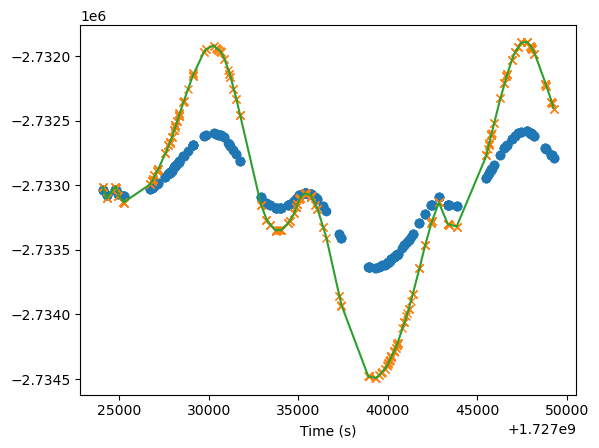

In [ ]:
plt.plot(updated_shotdata[:, 0], updated_shotdata[:, 1], "o", label="Updated Shot Data East")
plt.plot(shotdata_to_update[:, 0], shotdata_to_update[:, 1], 'x', label='Shot Data to Update East')
plt.plot(gnss_data_interpolation[gnss_training_data_inds, 0],
         gnss_data_interpolation[gnss_training_data_inds, 1],
         "-", label="Training Data East")
plt.xlabel("Time (s)")


In [ ]:

shotdata_df[shotdata_to_update_filter, 1:-1] = updated_shotdata
# set the isUpdated flag to True for the updated points
shotdata_df[shotdata_to_update_filter, -1] = True



ValueError: Length of values (345) does not match length of index (20503)